In [1]:
import matplotlib
%matplotlib inline
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from keras.models import Model
from keras.layers import Input, Reshape
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling1D, Conv1D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard

Using TensorFlow backend.


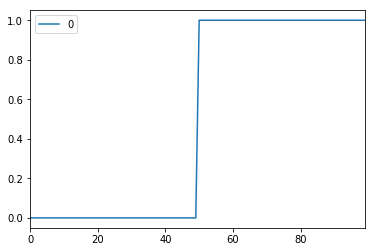

In [2]:
"""def sample_data(n_samples=10000, x_vals=np.arange(0, 5, .1), max_offset=100, mul_range=[1, 2]):
    vectors = []
    for i in range(n_samples):
        offset = np.random.random() * max_offset
        mul = mul_range[0] + np.random.random() * (mul_range[1] - mul_range[0])
        vectors.append(
            np.sin(offset + x_vals * mul) / 2 + .5
        )
    return np.array(vectors)
"""
# 실제 데이터 생성
def sample_data(n_samples=100):
    vectors = []
    for i in range(n_samples):
        listt =[]
        offset = 50
        for i in range(0,100):
            if offset > i:
                y = 0
            else:
                y = 1
            listt.append(y)
        vectors.append(listt)
    return np.array(vectors)  

# 데이터 생성 샘플
ax = pd.DataFrame(np.transpose(sample_data(1))).plot()

In [3]:
# sample_data 함수의 shape 확인
ax =sample_data(10)
ax.shape

(10, 100)

In [4]:
# 생성기 함수
#Output 차원 항상 확인
def get_generative(G_in, dense_dim=20, out_dim=100, lr=1e-3):
    x = Dense(dense_dim)(G_in)
    x = Activation('tanh')(x)
    G_out = Dense(out_dim, activation='tanh')(x)
    G = Model(G_in, G_out)
    opt = SGD(lr=lr)
    G.compile(loss='binary_crossentropy', optimizer=opt)
    return G, G_out

G_in = Input(shape=[100])
G, G_out = get_generative(G_in)
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2020      
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2100      
Total params: 4,120
Trainable params: 4,120
Non-trainable params: 0
_________________________________________________________________


In [5]:
#판별기 학습함수
def get_discriminative(D_in, lr=1e-3, drate=.25, n_channels=50, conv_sz=5, leak=.2):
    x = Reshape((-1, 1))(D_in)
    x = Conv1D(n_channels, conv_sz, activation='relu')(x)
    x = Dropout(drate)(x)
    x = Flatten()(x)
    x = Dense(n_channels)(x)
    D_out = Dense(2, activation='sigmoid')(x)
    D = Model(D_in, D_out)
    dopt = Adam(lr=lr)
    D.compile(loss='binary_crossentropy', optimizer=dopt)
    return D, D_out

#생성기의 출력과 판별기의 shape을 같도록 주의한다.
D_in = Input(shape=[100])
D, D_out = get_discriminative(D_in)
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 100, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 50)            300       
_________________________________________________________________
dropout_1 (Dropout)          (None, 96, 50)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4800)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                240050    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 102       
Total para

In [6]:
# model의 가중치 변경유무 설정 함수
def set_trainability(model, trainable=False):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable
# 생성기를 학습하는 함수        
def make_gan(GAN_in, G, D):
    set_trainability(D, False)
    x = G(GAN_in)
    GAN_out = D(x)
    GAN = Model(GAN_in, GAN_out)
    GAN.compile(loss='binary_crossentropy', optimizer=G.optimizer)
    return GAN, GAN_out

GAN_in = Input([100])
GAN, GAN_out = make_gan(GAN_in, G, D)
GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_1 (Model)              (None, 100)               4120      
_________________________________________________________________
model_2 (Model)              (None, 2)                 240452    
Total params: 244,572
Trainable params: 4,120
Non-trainable params: 240,452
_________________________________________________________________


In [7]:
#실제데이터와 생성데이터를 합쳐 학습에 사용하기 위한 함수
def sample_data_and_gen(G, noise_dim=100, n_samples=1000):
    XT = sample_data(n_samples=n_samples) #실제데이터
    XN_noise = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    XN = G.predict(XN_noise)  # 생성망을 통해 생성한 데이터
    X = np.concatenate((XT, XN))  #데이터를 합치기 위한 concatenate 함수
    y = np.zeros((2*n_samples, 2))
    y[:n_samples, 1] = 1
    y[n_samples:, 0] = 1
    return X, y
# D 판별망의 사전학습을 하는 함수
def pretrain(G, D, noise_dim=100, n_samples=100, batch_size=20):
    X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
    set_trainability(D, True)
    D.fit(X, y, epochs=1, batch_size=batch_size,verbose=1)

pretrain(G, D)

Epoch 1/1
200/200 [==============================] - ETA: 9s - loss: 0.689 - 1s 6ms/step - loss: 0.2132


Epoch #100: Generative Loss: 7.394103050231934, Discriminative Loss: 0.0005635220441035926
Epoch #200: Generative Loss: 6.9324798583984375, Discriminative Loss: 0.0014901916729286313
Epoch #300: Generative Loss: 7.0412211418151855, Discriminative Loss: 0.00614016130566597
Epoch #400: Generative Loss: 4.549797534942627, Discriminative Loss: 0.054269351065158844
Epoch #500: Generative Loss: 5.6457648277282715, Discriminative Loss: 0.25216755270957947



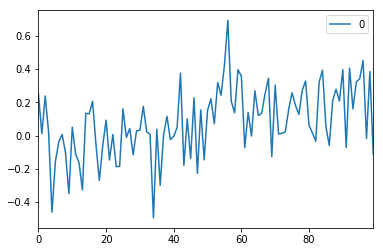

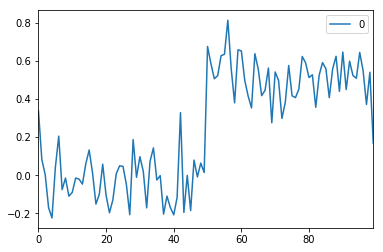

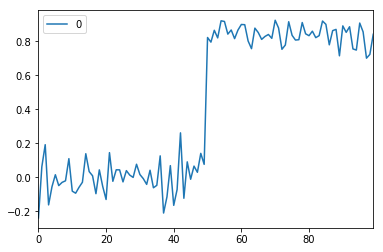

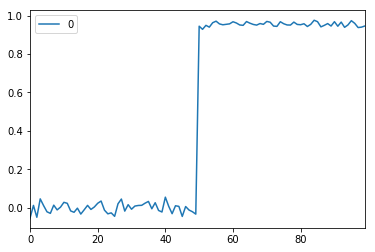

In [8]:
#노이즈를 생성하는 함수
def sample_noise(G, noise_dim=100, n_samples=1000):
    X = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    y = np.zeros((n_samples, 2))
    y[:, 1] = 1
    return X, y
# GAN을 학습하는 것으로 D의 가중치의 학습유무를 바꿔가면서 학습을 진행한다.
def train(GAN, G, D, epochs=500, n_samples=1000, noise_dim=100, batch_size=32, verbose=False, v_freq=100):
    d_loss = []
    g_loss = []
    e_range = range(epochs)
    if verbose:
        e_range = tqdm(e_range)
    for epoch in e_range:
        X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, True)
        d_loss.append(D.train_on_batch(X, y))

        X, y = sample_noise(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, False)
        g_loss.append(GAN.train_on_batch(X, y))
        if verbose and (epoch + 1) % v_freq == 0:
            print("Epoch #{}: Generative Loss: {}, Discriminative Loss: {}".format(epoch + 1, g_loss[-1], d_loss[-1]))
            N_VIEWED_SAMPLES = 1
            data_and_gen, k = sample_data_and_gen(G, n_samples=N_VIEWED_SAMPLES)
            pd.DataFrame(np.transpose(data_and_gen[N_VIEWED_SAMPLES:])).plot()
            plt.savefig('./epoch/Epoch#{}'.format(epoch + 1))
    plt.close()
    return d_loss, g_loss

d_loss, g_loss = train(GAN, G, D, verbose=True)

Text(0, 0.5, 'Loss')

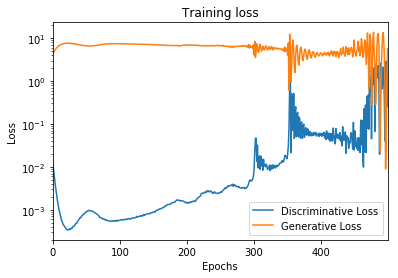

In [9]:
ax = pd.DataFrame(
    {
        'Generative Loss': g_loss,
        'Discriminative Loss': d_loss,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

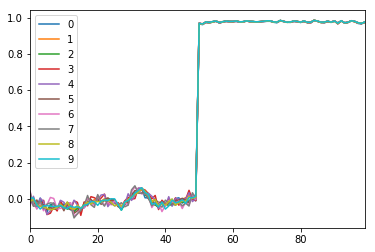

In [10]:
N_VIEWED_SAMPLES = 10
data_and_gen, k = sample_data_and_gen(G, n_samples=N_VIEWED_SAMPLES)
pd.DataFrame(np.transpose(data_and_gen[N_VIEWED_SAMPLES:])).plot()

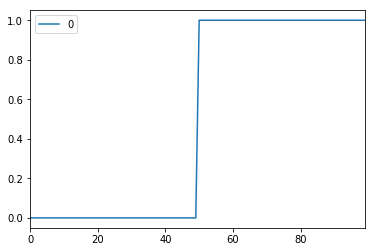

In [11]:
pd.DataFrame(np.transpose(data_and_gen[0])).plot()

In [12]:
real =pd.DataFrame(np.transpose(data_and_gen[0]))

In [13]:
gan_generate = pd.DataFrame(np.transpose(data_and_gen[11]))

In [14]:
real.to_csv("./real_data.csv",header =False, index =True)

In [15]:
gan_generate.to_csv("./fake_data.csv",header =False, index =True)